# Two subpopulations *E. coli* model

In this second example, we will build a monoculture, two subpopulation dynamic model of *E. coli* and run the dynamic FBA simulation on different environmental conditions. We assume you went through the single population notebook and became already familiar with the DAPHNE structures. 

Again, make sure the notebook kernel activated uses the daphnePy2 environment. 

We start by setting the path of the working dir and load the relevant packages.

In [1]:
%load_ext autoreload
%autoreload 2

# Change the absolute path of your daphne folder

DAPHNEPATH='/home/succurro/repositories/gitlab/daphne/'

In [2]:
# Load all the needed modules
import sys
sys.path.append(DAPHNEPATH+'code/python/')
import classModel as cmo
import classReaction as cre
import classMetabolite as cme
import classConsortium as cco
import classPlotter as plotter
import classConvertionFactors as ccf
import cobra
import pandas
from cobra.flux_analysis import parsimonious
import numpy as np
import matplotlib.pyplot as plt
import argparse
import plstyles
import random
import cPickle
import json
import copy
from matplotlib import gridspec


## Overview of the model

The new mathematical consists of two *E. coli* populations $\text{EC}_{Gl}$ and $\text{EC}_{Ac}$ that can consume exclusively glucose (Gl) or acetate (Ac), respectively. The ODE model has therefore one additional equation wrt the single *E. coli* model and is:

\begin{align*}
\dfrac{d \text{BM}_{\text{EC}_{Gl}}}{dt} &= ( v^{\text{EC}_{Gl}}_\mu - \psi -\delta ) \cdot \text{BM}_{\text{EC}_{Gl}} + \varepsilon \phi\text{BM}_{\text{EC}_{Ac}},\\
\dfrac{d \text{BM}_{\text{EC}_{Ac}}}{dt} &= (v^{\text{EC}_{Ac}}_\mu - \phi -\delta) \cdot\text{BM}_{\text{EC}_{Ac}} + \varepsilon \psi\text{BM}_{\text{EC}_{Gl}},\\
\dfrac{d \text{Gl}}{dt} &= v^{\text{EC}_{Gl}}_\text{EX_Gl_e}\cdot\text{BM}_{\text{EC}_{Gl}} +  v^{\text{EC}_{Ac}}_\text{EX_Gl_e}\cdot\text{BM}_{\text{EC}_{Ac}}  + {\xi_{\text{fed-batch}}},\\
\dfrac{d \text{Ac}}{dt} &= v^{\text{EC}_{Gl}}_\text{EX_Ac_e}\cdot\text{BM}_{\text{EC}_{Gl}} + (v^{\text{EC}_{Ac}}_\text{EX_Ac_e}  + {\zeta\cdot H(t-t_x)})\cdot\text{BM}_{\text{EC}_{Ac}}.
\end{align*}

Besides the two separate populations, the main difference wrt to the single *E. coli* model is the introduction of population transition functions $\psi: \text{EC}_{Gl} \rightarrow \text{EC}_{Ac}$ and $\phi: \text{EC}_{Ac} \rightarrow \text{EC}_{Gl}$, with transitions having an efficiency $\epsilon$. The transition functions are modeled as Hill functions with a noise offset:

\begin{align*}
\psi([\text{Ac}])  &= \psi_0 + V_M^{\psi}\dfrac{[\text{Ac}]^n}{[\text{Ac}]^n + {K_M^{\psi}}^n}\label{eq:psi},\\
\phi([\text{Gl}])  &= \phi_0 + V_M^{\phi}\dfrac{[\text{Gl}]^n}{[\text{Gl}]^n + {K_M^{\phi}}^n}\label{eq:phi},
\end{align*}


Additionally, the contribution to glucose and acetate changes are now split between the two populations. Note however that since $\text{EC}_{Ac}$ can only consume acetate, the FBA flux $v^{\text{EC}_{Ac}}_\text{EX_Gl_e}$ will have a lower bound of zero, and correspondingly the $v^{\text{EC}_{Gl}}_\text{EX_Ac_e}$ will have a lower bound of zero, but a positive upper bound, since $\text{EC}_{Gl}$ cannot consume acetate but can secrete it.

For the sake of clarity, we will repeat a few things that were already explained for the single *E. coli* model.

As before, this ODE model is linked to a SBML model, in our example the [*E.  coli* core model](http://bigg.ucsd.edu/models/e_coli_core), and we have have to define the SBML-dependent names of the reactions that we plan to follow over time. Important to notice is that each population will have an independent SBML model linked.

In order to translate this theoretical model into a DAPHNE model, we need to understand what the different components are. 

### Metabolites (classMetabolite)

The model consists of 4 equations following the temporal variation in the quantity of 4 "dynamic metabolites" DMetabolite or Biomass (which inherits from DMetabolite) objects:

* $\text{BM}_{\text{EC}_{Gl}}$, the glucose consuming population biomass, which is to be initialized as a classMetabolite.Biomass object
* $\text{BM}_{\text{EC}_{Ac}}$, the acetate consuming population biomass, which is to be initialized as a classMetabolite.Biomass object
* Gl, glucose, a classMetabolite.DMetabolite object
* Ac, acetate, a classMetabolite.DMetabolite object

For these metabolites we need also initialization values, which depend on the environment/condition.

### Reactions (classReaction)

\begin{align*}
\dfrac{d \text{BM}_{\text{EC}_{Gl}}}{dt} &= (\color{red}{v^{\text{EC}_{Gl}}_\mu} - \color{blue}{\psi} -\color{blue}{\delta} ) \cdot \text{BM}_{\text{EC}_{Gl}} + \varepsilon \color{blue}{\phi}\text{BM}_{\text{EC}_{Ac}},\\
\dfrac{d \text{BM}_{\text{EC}_{Ac}}}{dt} &= (\color{red}{v^{\text{EC}_{Ac}}_\mu} - \color{blue}{\phi} -\color{blue}{\delta}) \cdot\text{BM}_{\text{EC}_{Ac}} + \varepsilon \color{blue}{\psi}\text{BM}_{\text{EC}_{Gl}},\\
\dfrac{d \text{Gl}}{dt} &= \color{red}{v^{\text{EC}_{Gl}}_\text{EX_Gl_e}}\cdot\text{BM}_{\text{EC}_{Gl}} +  \color{red}{v^{\text{EC}_{Ac}}_\text{EX_Gl_e}}\cdot\text{BM}_{\text{EC}_{Ac}} + \color{blue}{\xi_{\text{fed-batch}}}, \\
\dfrac{d \text{Ac}}{dt} &= \color{red}{v^{\text{EC}_{Gl}}_\text{EX_Ac_e}}\cdot\text{BM}_{\text{EC}_{Gl}}+ (\color{red}{v^{\text{EC}_{Ac}}_\text{EX_Ac_e}}  + \color{blue}{\zeta\cdot H(t-t_x)})\cdot\text{BM}_{\text{EC}_{Ac}}.
\end{align*}

There are 11 reactions (in a general sense) in the equations, 6 of them linked to flux solutions from the FBA problem (highlighted in red) and 5 that are independent of the FBA solution (highlighted in blue). We need to define a "dynamic reaction" DReaction object only for those reactions that have rates changing over time:

* $v^{\text{EC}_{Gl}}_\mu$, the biomass flux solution for the glucose consumer population, retrieved from FBA
* $v^{\text{EC}_{Gl}}_\text{EX_Gl_e}$, the glucose consumption rate for the glucose consumer population, retrieved from FBA
* $v^{\text{EC}_{Gl}}_\text{EX_Ac_e}$, the acetate consumption/secretion rate for the glucose consumer population, retrieved from FBA
* $v^{\text{EC}_{Ac}}_\mu$, the biomass flux solution for the acetate consumer population, retrieved from FBA
* $v^{\text{EC}_{Ac}}_\text{EX_Gl_e}$, the glucose consumption rate for the acetate consumer population, retrieved from FBA
* $v^{\text{EC}_{Ac}}_\text{EX_Ac_e}$, the acetate consumption/secretion rate for the acetate consumer population, retrieved from FBA
* $\zeta\cdot H(t-t_x)$, a step function for the feeding of acetate at a certain time point, condition dependent
* $\psi$, a transition function describing the shift $\text{EC}_{Gl} \rightarrow \text{EC}_{Ac}$
* $\phi$, a transition function describing the shift $\text{EC}_{Ac} \rightarrow \text{EC}_{Gl}$

We do not need a DReaction object for:

* $\delta$, the cell death rate, a fixed parameter
* $\xi_{\text{fed-batch}}$, the fed-batch rate for glucose, a fixed parameter condition dependent




## Model construction

### Initialization of parameters, labels etc.

We start initializing the parameters and other elements for the simulations.

In [3]:
## SBML model to load
mpath = DAPHNEPATH+'ecoli/bigg/e_coli_core.xml'

## Biomass function name and reaction names in the SBML model
bmf = 'BIOMASS_Ecoli_core_w_GAM'
rxnnames = {'EX_glc_e':'EX_glc__D_e', 
            'EX_o2_e': 'EX_o2_e',
            'EX_ac_e':'EX_ac_e'}

## General labels
label='diauxic_shift'
ename = 'ecoli core'

### Experimental conditions (from Enjalbert et al. 2015)

We will use as examples the 3 experimental conditions from Enjalbert et al., namely:

1. Batch Growth on 15mM Glucose
2. Batch Growth on 15mM Glucose and feeding of acetate upon glucose exhaustion to maintain a concentration of 4mM Acetate
3. Batch Growth on 15mM Glucose and constant feeding of acetate to maintain a concentration of 32mM Acetate

However, you can also define other environmental conditions.

In [4]:
# Initialize parameters environment and condition dependent to 0
expcond = 'NA'
biomass0 = 0.
glucose0 = 0.0 #mM
acetate0 = 0.0 #mM
ac_thr = 0.0
# Glucose fed-batch paramter
fb=0.
# Acetate feeding paramter
afb=0.
# Time at which glucose is exhausted and acetate feeding starts (Enjalbert et al. 2015 conditions)
t_glc = 0.0
# percentage of population in the glucose consuming state
pcECgl = 0.0

# Approximate convertion valute from OD to gDW measurement
ODtoGDW=0.33
# Biomass dilution rate in chemostat, 1/hr
ch = 0.
# Cell death rate
death_rate = -0.03
# Conditions from Enjalbert et al. 2015
volExt = 0.03
volUn = 'L'
expcondLabels = {'batch_low_Glc': 'grown on 15 mM Glc',
                 'fedbatch_low_Ac': 'grown on 15 mM Glc, fed 4 mM Ac',
                 'fedbatch_high_Ac': 'grown on 15 mM Glc, fed 32 mM Ac'}

# Efficiency for population transition, see later for explanation
transition_efficiency = 0.9


# Set flags for the 3 conditions of interest
# Set one condition flag to True
runbatchglc = False
runfedlowacetate = False
runfedhighacetate = True

if runbatchglc:
    print('Simulating Batch Growth on 15mM Glucose as in Enjalbert2015')
    expcond = 'batch_low_Glc'
    biomass0 = 0.0027
    glucose0 = 15.0 #mM
    acetate0 = 0.0 #mM
    fb = 0.
    afb = 0.
    pcECgl = 0.95
elif runfedlowacetate:
    print('Simulating Batch Growth on 15mM Glucose and constant 4mM Acetate as in Enjalbert2015')
    expcond = 'fedbatch_low_Ac'
    biomass0 = 0.0038
    glucose0 = 15.0
    acetate0 = 0.0
    afb = 1.0
    ac_thr = 4.0
    t_glc = 4.0
    pcECgl = 0.95
elif runfedhighacetate:
    print('Simulating Batch Growth on 15mM Glucose and constant 32mM Acetate as in Enjalbert2015')
    expcond = 'fedbatch_high_Ac'
    biomass0 = 0.006
    glucose0 = 15.0
    acetate0 = 32.0
    afb = 1.0
    ac_thr = 32.0
    t_glc = 4.0
    pcECgl = 0.75
else:
    print('Simulating custom conditions')

## Units:
## biomass0 is already gDW
## glucose0 and acetate0 are concentrations (mM)
## dMetabolites are initialized with quantities (mmol)
acetate0 = volExt*acetate0 # mM*L = mmol
glucose0 = volExt*glucose0 # mM*L = mmol

Simulating Batch Growth on 15mM Glucose and constant 32mM Acetate as in Enjalbert2015


### FBA flux constraints

We now define the fixed parameters to constrain the FBA problem. These values are taken from literature and are not changed for the different conditions, and are the same as in the single population model. For glucose and acetate uptake, they are used to define a Michaelis-Menten kinetics.

In [5]:
## Fixed FBA related parameters
## Uptake Vmax 10 mmol/g/hr (Gosset, 2005)
## Uptake Km 10 muM = 0.01 mM (Gosset, 2005)
vmaxexglc = 10. #mmol/g/hr
vmaxexace = 10. #mmol/g/hr
kmuptake = 0.01 #mM
## Parametrized with Varma 1994
vminoxygen = -11.5
ubexace = 3.0

### Two DynamicModels

We now need to first build two independent DynamicModels, one per population. For the details on DMetabolite and DReaction definitions, please refer to the single *E. coli* notebook.


We now initialize 6 dynamic metabolites. It is important to know that in order to build a consortium model, we need to first build two independent single organism models. Therefore, the  

As described for the single *E. coli* model, the initialization of a DMetabolite object requires the following arguments:

#### Glucose consumer 



In [6]:
biomass_ECgl = cme.Biomass([biomass0*pcECgl], {'growth': [(1, 'biomass_ECgl')], 'death': [(death_rate, 'biomass_ECgl')],
                                            'psi_transition': [(-1., 'biomass_ECgl')], 'phi_transition': [(transition_efficiency, 'biomass_ECac')]})
ex_glucose_ECgl = cme.DMetabolite('glc_D_e', [glucose0], False, {'glucose_exchange': [(1, 'biomass_ECgl')], 'glucose_fed': [(fb, None)] })
ex_acetate_ECgl = cme.DMetabolite('ac_e', [acetate0], False, {'acetate_exchange': [(1, 'biomass_ECgl')]})

oxygen_exchange_ECgl = cre.DReaction(rxnnames['EX_o2_e'], cre.FixedBound(vminoxygen, 0), False)
### Only Ac secretion
acetate_exchange_ECgl = cre.DReaction(rxnnames['EX_ac_e'], cre.FixedBound(0., ubexace), True)
glucose_exchange_ECgl = cre.DReaction(rxnnames['EX_glc_e'], cre.MichaelisMenten1(ex_glucose_ECgl, 1, vmaxexglc, kmuptake, 1, upperBound=15.), False)
growth_ECgl = cre.DReaction(bmf, cre.FixedBound(0., 1000.))


#### Acetate consumer

In [7]:
biomass_ECac = cme.Biomass([biomass0*(1-pcECgl)], {'growth': [(1, 'biomass_ECac')], 'death': [(death_rate, 'biomass_ECac')],
                                                'psi_transition': [(transition_efficiency, 'biomass_ECgl')], 'phi_transition': [(-1., 'biomass_ECac')]})
ex_glucose_ECac = cme.DMetabolite('glc_D_e', [glucose0], False, {'glucose_exchange': [(1, 'biomass_ECac')] })
ex_acetate_ECac = cme.DMetabolite('ac_e', [acetate0], False, {'acetate_exchange': [(1, 'biomass_ECac')], 'acetate_fed': [(afb, 'biomass_ECac')]})
    
oxygen_exchange_ECac = cre.DReaction(rxnnames['EX_o2_e'], cre.FixedBound(vminoxygen, 0), False)
acetate_exchange_ECac = cre.DReaction(rxnnames['EX_ac_e'], cre.MichaelisMenten1(ex_acetate_ECac, 1, vmaxexace, kmuptake, 1, upperBound=ubexace), False)
### EX_glc off
glucose_exchange_ECac = cre.DReaction(rxnnames['EX_glc_e'], cre.FixedBound(0.,0.), False)
growth_ECac = cre.DReaction(bmf, cre.FixedBound(0., 1000.))
acetate_fed_ECac = cre.DReaction(None, cre.SquareWave(9.1, 20, 1, t_glc), True, isODE=True)


### Transition functions

The transition functions are modeled as Hill functions with a noise offset:

\begin{align*}
\psi([\text{Ac}])  &= \psi_0 + V_M^{\psi}\dfrac{[\text{Ac}]^n}{[\text{Ac}]^n + {K_M^{\psi}}^n}\label{eq:psi},\\
\phi([\text{Gl}])  &= \phi_0 + V_M^{\phi}\dfrac{[\text{Gl}]^n}{[\text{Gl}]^n + {K_M^{\phi}}^n}\label{eq:phi},
\end{align*}

These heuristic functions are chosen to represent different transition modes. The noise offsets $\psi_0$ and $\phi_0$ represent a purely stochastic component, while the Hill functions represent a responsive component that is environment-dependent. In the [mSystems paper](https://msystems.asm.org/content/4/1/e00230-18) we compared three transition scenarios:

![shifts](shifts.png)

The uniform shift is modeles as a single *E. coli* population model (see the correspondent notebook), the stochastic shift as a two subpopulation model with transition functions with only the offset component, and the responsive shift as a two subpopulation model with transition functions with offset and Hill components.

The parameter values were chosen from a range selected with a simplified mathematical model (see the publication for details).

In [8]:
# Set flags for the 3 types of transitions
# Set one transition flag to True
# Else, default is no transition
notransition = False
stochastictransition = False
responsivetransition = True

psi0 = 0.
psi_transition_rate = 0.
psi_transition_KM = 0.
phi0 = 0.
phi_transition_rate = 0.
phi_transition_KM = 0.

if stochastictransition:
    psi0=0.04
    phi0=0.04
elif responsivetransition:
    psi0=0.04
    phi0=0.04
    psi_transition_KM=30.0
    phi_transition_KM=5.0
    psi_transition_rate=0.2
    phi_transition_rate=0.2

## The Hill coefficient is heuristically set to 5
hctrans = 5

## We need to duplicate the functions so that the update step does not conflict among models
## phi = Glc -> Ac ##
## ECglc senses Ac and transitions
biomass_psi_transition_ECgl = cre.DReaction(None, cre.MichaelisMentenLinked(ex_acetate_ECgl, lowerBound=0.,
                                                                            maxVelocity=psi_transition_rate, hillCoeff=hctrans,
                                                                            mmConstant=psi_transition_KM, linkedReaction=None, onThr=0., offset=psi0), True, isODE=True)
biomass_psi_transition_ECac = cre.DReaction(None, cre.MichaelisMentenLinked(ex_acetate_ECgl, lowerBound=0.,
                                                                            maxVelocity=psi_transition_rate, hillCoeff=hctrans,
                                                                            mmConstant=psi_transition_KM, linkedReaction=None, onThr=0., offset=psi0), True, isODE=True)
## phi = Ac -> Glc ##
## ECac senses Glc and transitions
biomass_phi_transition_ECac = cre.DReaction(None, cre.MichaelisMentenLinked(ex_glucose_ECac, lowerBound=0.,
                                                                            maxVelocity=phi_transition_rate, hillCoeff=hctrans,
                                                                            mmConstant=phi_transition_KM, linkedReaction=None, onThr=0., offset=phi0), True, isODE=True)
biomass_phi_transition_ECgl = cre.DReaction(None, cre.MichaelisMentenLinked(ex_glucose_ECac, lowerBound=0.,
                                                                            maxVelocity=phi_transition_rate, hillCoeff=hctrans,
                                                                            mmConstant=phi_transition_KM, linkedReaction=None, onThr=0., offset=phi0), True, isODE=True)


### DynamicModel

We now have to initialize the DynamicModel objects as well as the Consortium object. The DynamicModel object needs the following arguments:

1. A dictionary of the DReaction objects constituting the model, the keys of the dictionary must be consistent with the keys previously used to initialize the DMetabolite objects.
2. A dictionary of the DMetabolite objects constituting the model, the keys of the dictionary must be consistent with the keys previously used to initialize the DMetabolite objects.
3. The path to the SBML model.
4. The volume of the environment.
5. The units of the volume.
6. The solver to be used to solve the FBA problem.
7. A name to be used to save the model.
8. The path where to store the simulation output (pickle file).

The Consortium object needs the following arguments:

1. A dictionary of the DynamicModels forming the consortium
2. A dictionary of all the DMetabolites that are updated while simulating the consortium, and which DynamicModel has effect on them
3. The solver to be used to solve the FBA problem.
4. A name to be used to save the model.
5. The path where to store the simulation output (pickle file).


In [9]:
exitname = '%s-%s-%s' % (ename, expcond, label) 

dyRxn_ECgl = {'glucose_exchange': glucose_exchange_ECgl, 
      'oxygen_exchange': oxygen_exchange_ECgl,
      'acetate_exchange': acetate_exchange_ECgl,
      'psi_transition': biomass_psi_transition_ECgl,
      'phi_transition': biomass_phi_transition_ECgl,
      'growth': growth_ECgl}
dyMet_ECgl = {'biomass_ECgl': biomass_ECgl,
      'ex_glucose': ex_glucose_ECgl,
      'ex_acetate': ex_acetate_ECgl}

model_ECgl = cmo.DynamicModel(dyRxn_ECgl, dyMet_ECgl, mpath, volExt, volUn, 'optlang-glpk', exitname+'_ECgl', savePath='./')

dyRxn_ECac = {'glucose_exchange': glucose_exchange_ECac, 
      'oxygen_exchange': oxygen_exchange_ECac,
      'acetate_fed': acetate_fed_ECac,
      'acetate_exchange': acetate_exchange_ECac,
      'psi_transition': biomass_psi_transition_ECac,
      'phi_transition': biomass_phi_transition_ECac,
      'growth': growth_ECac}
dyMet_ECac = {'biomass_ECac': biomass_ECac,
      'ex_glucose': ex_glucose_ECac,
      'ex_acetate': ex_acetate_ECac}

model_ECac = cmo.DynamicModel(dyRxn_ECac, dyMet_ECac, mpath, volExt, volUn, 'optlang-glpk', exitname+'_ECac', savePath='./')

model_ECgl.loadSBMLModel()
model_ECgl.resetObjective()
model_ECgl.setObjective(growth_ECgl.modName, 1.)
model_ECgl.constrainSources(element='C', count=0, uptakeOff=True)
model_ECgl.initializeConcentrations()
model_ECgl.setParsimoniousFBA(True)
model_ECgl.setMinimalMaintenance(growth_ECgl.modName, -0.15)
model_ECgl.setQuitOnFBAError(False)
model_ECgl.setBoundsThreshold(0.8*vmaxexglc)
model_ECgl.cbModel.reactions.get_by_id('ATPM').upper_bound = 8.39
model_ECgl.cbModel.reactions.get_by_id('ATPM').lower_bound = 8.39

model_ECac.loadSBMLModel()
model_ECac.resetObjective()
model_ECac.setObjective(growth_ECac.modName, 1.)
model_ECac.constrainSources(element='C', count=0, uptakeOff=True)
model_ECac.initializeConcentrations()
model_ECac.setParsimoniousFBA(True)
model_ECac.setMinimalMaintenance(growth_ECac.modName, -0.15)
model_ECac.setQuitOnFBAError(False)
model_ECac.setBoundsThreshold(0.8*vmaxexace)
model_ECac.cbModel.reactions.get_by_id('ATPM').upper_bound = 8.39
model_ECac.cbModel.reactions.get_by_id('ATPM').lower_bound = 8.39

model_comm = cco.Consortium({'ECgl': model_ECgl, 'ECac': model_ECac},
    {'biomass_ECgl': ['ECgl'], 
     'biomass_ECac': ['ECac'],
     'ex_glucose': ['ECgl', 'ECac'],
     'ex_acetate': ['ECgl', 'ECac']
    }, 'optlang-glpk', name=exitname+'_ECgl_ECac_', savePath='./')

### Run the simulation

We can now run the simulation, using the runConsortiumDynamicFBA method. It needs as argument:

1. Maximal simulated time (in hours) after which it will exit.
2. Method for the ODE integration.
3. Tuple for the parameters of the ODE integration: (flag for the integration mode, minimal step size, maximal step size, maximum number of steps).
4. Boolean flag, True for verbose output.
5. Boolean flag, True to quit upon an infeasible FBA solution.


In [10]:
## Set simulation parameters
maxtime = 10.5
minstep = 0.0
nsteps = 10000

## Start simulation
model_comm.runConsortiumDynamicFBA(maxtime, 'vode', (0, minstep, 1., nsteps), verbose=False)

LP Solver called by pfba() raised an exception at T[1123] = 3.80; not quitting yet
No FBA Solution: status  error
Continue without FBA: FBA error at T[1123] = 3.80
End of dFBA simulation, stopDFBA message:
	Everything OK


### Plot the output

We can now plot the simulation result, overlaying the data from Enjalbert et al. 2015. For this we load the function defined in the file plotFunctions.py.


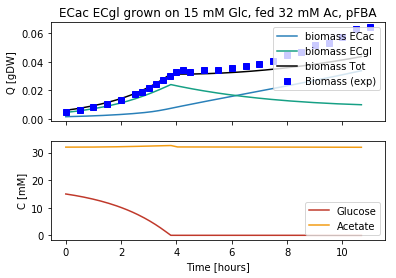

In [11]:
%reload_ext autoreload
%autoreload 2

from plotFunctions import plotEnjalbert2015_growth2EC

plotEnjalbert2015_growth2EC(model_comm, expcond, '-'.join(exitname.split('-')[1:]), DAPHNEPATH)